In [1]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  
import matplotlib
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [2]:
## key frames
# all_data: has multiple rows per cell (cell_id x CNV)
# merged_cell_data: 1 row per cell, extra rows for truncal cells (with signatures estimated from all clonal mutations or per cell)
# merged_cell_data2: includes merged_cell_data, also  mean_median_mrca_burden,cell_trunk_df,merged_normal_cells, through concatenation
#           when concatenating, adding relevant entries to data_type column, so we can distinguish if a data point corresponds to a cell or other summary entities

In [3]:
genome_size_mb=2800

In [4]:
# inputs
# metadata

# metadata: for translating between different sample name conventions, eg BTE1 vs BT36
metadata_fn = '../../data_scNanoSeq/intermediate/sample_ID_mapping_dg_annot_tumor_cells.txt'
# annotated_cell_list: used to create a normal cell list, tumor cell list and remnant cells
annotated_cell_list_fn = '../../data_scNanoSeq/intermediate/scNanoSeq_metadata_v5.csv'
# total number of detected mutations per sample
mut_count_fn = '../../data_scNanoSeq/intermediate/mutation_counts_per_cell.csv'


# mutation data
 # all_data: power corrected mutational burden per cell
cell_burden_folder = '../../data_scNanoSeq/intermediate/scNanoSeq_gnomAD_PowerCorrectedMutBurdens/'
# trunk_data_bulk: power corrected mutational burdens per cell, only including mutations that overlap with the bulk deep WGS
cell_bulk_trunk_burden_folder = '../../data_scNanoSeq/intermediate/scNanoSeq_TRUNK_Ultradeep_v2_power_corrected_burdens/'

# coverage in matched 
# bulkcov_stats: evaluating the proportion of mutations that are not included, per cell, because the coverage of matched normal sample is too low. This varies from sample to sample
BULKCOV_stats_fn = '../../data_scNanoSeq/intermediate/BULKCOV_stats_per_cell.csv'
# cell_clonal_cnv_footprint: total footprint of CNV regions, stratified by total copy number
cell_cnv_footprint = '../../data_scNanoSeq/intermediate/cellCnvClonalList_v2.csv'

# signatures
# all mutations per cell
new_sc_exp_fn = '../../data_scNanoSeq/intermediate/sig_exposures/scNanoSeq_perCell_BasicSigsSet_Feb25_v3.csv'
# clonal exposures (bulk-defined): CURRENT
new_clonal_exp_fn = '../../data_scNanoSeq/intermediate/sig_exposures/H_trunk_Ultradeep_ClonalThresh.csv'
# normal cells merged exposures
normal_merged_exp_fn = '../../data_scNanoSeq/intermediate/sig_exposures/H_Grouped_Normal_Cells_v4.csv'

In [5]:
# outputs
per_cell_sigs_exposures_fn = '../../data_scNanoSeq/output/scNanoseq_diploid_burdens_with_signatures_Feb25_selected.csv'


In [6]:
# plots
figure5a_fn='../../data_scNanoSeq/plots//Figure5A.pdf'
figure5b_fn='../../data_scNanoSeq/plots/Figure5B.pdf'
figure5c='../../data_scNanoSeq/plots/Figure5C.pdf'
figure5d='../../data_scNanoSeq/plots/Figure5D.pdf'
power_fig_fn='../../data_scNanoSeq/plots/powerAcrossCells.pdf'

In [7]:
# sample_name metadata
metadata = pd.read_csv(metadata_fn, sep=',')
metadata = metadata[['Sample_ID_internal', 'Sample_ID_ms', 'Truncal.node', 'no_tumor_cells', 'tumor_cells']]
cancer_cells = []
for index, row in metadata.iterrows():
    cancer_cells = cancer_cells + row['tumor_cells'].split(';')
snames_df=metadata.loc[:,['Sample_ID_internal', 'Sample_ID_ms']].copy()
sample_id_dict = snames_df.set_index('Sample_ID_internal')['Sample_ID_ms'].to_dict()

annotated_cell_list = pd.read_csv(annotated_cell_list_fn)
normal_curated_cells = []
for index, row in annotated_cell_list.iterrows():
    if pd.notna(row['non_tumor_cells_curated_standardized']):
        normal_curated_cells += row['non_tumor_cells_curated_standardized'].split(',')
transformed_cancer_cells = []
for index, row in annotated_cell_list.iterrows():
    transformed_cancer_cells  += row['tumor_cells'].split(',')

remnant_cells = []
for index, row in annotated_cell_list.iterrows():
    if not pd.isna(row['remnant_cells']):
        remnant_cells += str(row['remnant_cells']).split(',')

normal_curated_cells = [sample_id_dict[cell.split('_')[0]] + '_' + cell.split('_')[1] for cell in normal_curated_cells]
transformed_cancer_cells = [sample_id_dict[cell.split('_')[0]] + '_' + cell.split('_')[1] for cell in transformed_cancer_cells]
remnant_cells = [sample_id_dict[cell.split('_')[0]] + '_' + cell.split('_')[1] for cell in remnant_cells]


In [8]:
def compileCellBurdens(resultPath):
    """
    Compile cell burden statistics and save results.

    Parameters:
        resultPath (str): Path to the directory where output files will be retrieved from

    Returns:
        all_data: a data frame will have #cells x #copy number states (1..5) rows
            mut_burden_per_multiplicity: corrected mutation burden, split per multiplicity
            analytical_power_g: analytical power to detect mutations, calculated per multiplicity
            mut_count: detected mutation count
            power_burden_product_sum: corrected mutation burden times power: should be the detected mutation count (or close)
    """
    
    # there are folders CN1, CN2, through CN5
    file_paths = glob.glob(resultPath + 'CN*_regions_corr_power_output/*_power_corrected_results.csv')

    # Add file path as a new column in each dataframe
    
    # Load all tables into a list of dataframes
    # there will be a data frame for CN1, CN2, ..., CN5
    dataframes = [pd.read_csv(file) for file in file_paths]
    
    for i, df in enumerate(dataframes):
        df['file_path'] = file_paths[i]
        
    # concatenate all dataframes into a single dataframe, combining all results per cell
    all_data = pd.concat(dataframes, ignore_index=True)
    all_data['CN'] = all_data['file_path'].str.extract(r'CN(\d+)_')
    all_data['sample_name'] = all_data['cell_name'].str.extract(r'([^_]+)_')

    # extract corrected mutational burden per multiplicity as columns
    mut_burden_df = all_data['mut_burden_per_multiplicity'].apply(lambda x: pd.Series([int(i) for i in x.strip('[]').split()]))
    # Rename the new columns
    mut_burden_df.columns = [f'mut_burden_{i+1}' for i in mut_burden_df.columns]

    # extract mutation detection power, per multiplicity
    power_df = all_data['analytical_power_g'].apply(lambda x: pd.Series([float(i) for i in x.strip('[ ]').split()]))
    # Rename the new columns
    power_df.columns = [f'power_df_{i+1}' for i in power_df.columns]

    # extract numbers of detected mutations as columns, per multiplicity
    mut_count_df = pd.Series(all_data['mut_count'].apply(lambda x: pd.Series([int(i) for i in x.strip('[]').split(',')])).sum(axis=1))
    mut_count_df.name='detected_muts'

    # corrected mutation burden times power: should be the detected mutation count (or close)    
    power_burden = pd.Series((mut_burden_df * power_df.values).sum(axis=1))
    power_burden.name = 'power_burden_product_sum'

    # Concatenate the new columns with the original dataframe
    all_data = pd.concat([all_data, mut_burden_df, mut_count_df, power_burden], axis=1)
    # total corrected mutation burden per cell x (total copy number) 
    all_data['total_burden'] = mut_burden_df.sum(axis=1, skipna=True)

    # rows in this data frame correspond to cell/CN 

    return all_data

In [9]:
all_data = compileCellBurdens(cell_burden_folder)
# calculate cell G
# this table contains the following columns: cellID	cnv	footprint_bp	sample
cell_clonal_cnv_footprint = pd.read_csv(cell_cnv_footprint, index_col=0)
# ploidy across all cells
all_data['CN'] = all_data['CN'].astype(float)
all_data = pd.merge(all_data, cell_clonal_cnv_footprint, left_on=['cell_name', 'CN'], right_on=['cellID', 'cnv'], how='left' )
# rows are cells/copy number states

trunk_data_bulk = compileCellBurdens(cell_bulk_trunk_burden_folder)


In [10]:
mut_count_df = pd.read_csv(mut_count_fn).iloc[:,[0,2]]
mut_count_df.columns = ['cell_name', 'raw_mutation_count']
mut_count_df.head(1)

,cell_name,raw_mutation_count
0,BTE1_sc001,161


In [11]:
# calculate cell-counted ploidy
cell_ploidy = (
    all_data
    .groupby('cell_name')
    .apply(lambda group: (group['CN'] * group['length_in_CN[Mb]']).sum() / group['length_in_CN[Mb]'].sum())
    .reset_index(name='weighted_avg_CN')
)

cell_ploidy['sample'] = cell_ploidy['cell_name'].str[:4]
cell_ploidy['isTumor'] = cell_ploidy['cell_name'].isin(transformed_cancer_cells)
sample_ploidy = cell_ploidy[cell_ploidy['isTumor']==True].groupby('sample').agg({'weighted_avg_CN': 'median'}).reset_index()
cell_ploidy.head(1)


/tmp/ipykernel_3136766/2855652749.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: (group['CN'] * group['length_in_CN[Mb]']).sum() / group['length_in_CN[Mb]'].sum())


,cell_name,weighted_avg_CN,sample,isTumor
0,BTE1_sc001,3.43353,BTE1,True


In [12]:
mut_count_df.head()

,cell_name,raw_mutation_count
0,BTE1_sc001,161
1,BTE1_sc002,308
2,BTE1_sc004,82
3,BTE1_sc005,171
4,BTE1_sc008,207


In [13]:

# the rows correspond to cell x (total copy number)
all_data['mult_sum'] = (all_data['mut_burden_1'].fillna(0)  + all_data['mut_burden_2'].fillna(0) * 2 + all_data['mut_burden_3'].fillna(0) * 3 + all_data['mut_burden_4'].fillna(0) * 4)
all_data['m_over_T_sum'] = all_data['mult_sum'] / all_data['CN']


# these are estimates of trunk mutation burden where bulk WGS data is available
trunk_data_bulk['mult_sum_trunk_bulk'] = (trunk_data_bulk['mut_burden_1'].fillna(0)  + trunk_data_bulk['mut_burden_2'].fillna(0) * 2 + trunk_data_bulk['mut_burden_3'].fillna(0) * 3 + trunk_data_bulk['mut_burden_4'].fillna(0) * 4)
trunk_data_bulk['m_over_T_sum_trunk_bulk'] = trunk_data_bulk['mult_sum_trunk_bulk'] / trunk_data_bulk['CN'].astype(float)

# make a per cell summary (aggregating mutations across copy number states)
# aggreggate data to per cell statistics
# all mutations detected in a cell
aggregated_all_data = all_data.groupby('cell_name').agg({'m_over_T_sum': 'sum', 
                                                         'length_in_CN[Mb]' : 'sum',
                                                         'total_burden': 'sum',
                                                         'mult_sum': 'sum',
                                                         'footprint_bp' : 'sum',
                                                         'detected_muts' : 'sum',
                                                         'power_burden_product_sum' : 'sum'}).reset_index()

# only the mutations that were also detected in the trunk
aggregated_cell_trunk_bulk_burden = trunk_data_bulk.groupby('cell_name').agg({
                                                             'total_burden': 'sum',
                                                             'mult_sum_trunk_bulk': 'sum',
                                                             'm_over_T_sum_trunk_bulk' : 'sum',
                                                             'detected_muts' : 'sum',
                                                            'power_burden_product_sum' : 'sum'
                                                             }).reset_index()
aggregated_cell_trunk_bulk_burden.columns = ['cell_name','trunk_bulk_total_burden', 'mult_sum_trunk_bulk', 'm_over_T_sum_trunk_bulk', 'detected_muts_trunk_bulk', 'power_burden_product_sum_trunk_bulk']

# rows in this data frame correspond to cells
merged_cell_data = aggregated_all_data
merged_cell_data = pd.merge(merged_cell_data, aggregated_cell_trunk_bulk_burden, how='left')
merged_cell_data = pd.merge(merged_cell_data, mut_count_df,  how='left') # there is a problem here for BTE3
merged_cell_data = pd.merge(merged_cell_data, cell_ploidy[['cell_name','weighted_avg_CN']], how='left')

# effective genome size, calculated from all mutations after power correction
merged_cell_data['G'] = merged_cell_data['total_burden'] / merged_cell_data['m_over_T_sum'] 
# averge multiplicity
merged_cell_data['mult_avg']= merged_cell_data['mult_sum']/merged_cell_data['total_burden'] 
# averge multiplicity for truncal mutations (where available)
merged_cell_data['mult_avg_trunk_bulk']= merged_cell_data['mult_sum_trunk_bulk']/merged_cell_data['trunk_bulk_total_burden'] 
# burden corrected by effective genome size and footprint of the genome with with total copy number of 1 to 5
merged_cell_data['burden_diploid'] = 2 * merged_cell_data['m_over_T_sum'] * genome_size_mb / merged_cell_data['length_in_CN[Mb]']
# equivalent for the trunk
merged_cell_data['burden_trunk_bulk_diploid'] = 2 *merged_cell_data['m_over_T_sum_trunk_bulk'] * genome_size_mb / (merged_cell_data['footprint_bp']/1e6)

# the logic is that if a cell is in the transformed_list, it will be considered a tumor cell, and normal otherwise
merged_cell_data['isTumor'] = merged_cell_data['cell_name'].isin(transformed_cancer_cells)
merged_cell_data['sample_id'] = merged_cell_data['cell_name'].str.split('_').str[0]
# sample_id x T (Tumor) or N (Normal)
merged_cell_data['sample_id_TN'] = merged_cell_data['sample_id'] + '_' + merged_cell_data['isTumor'].map({True: 'T', False : 'N'})

# data on putatively somatic mutations filtered out because sequencing coverage in matched normal sample is less than 20
bulkcov_stats = pd.read_csv(BULKCOV_stats_fn)

aggregated_cell_footprint = all_data.groupby('cell_name').agg({'length_in_CN[Mb]': 'sum'}).reset_index()
merged_cell_data = pd.merge(merged_cell_data, aggregated_cell_footprint)
merged_cell_data = pd.merge(merged_cell_data, bulkcov_stats, left_on = 'cell_name', right_on='cell', how='left')


# correct by percentage of discarded mutations (because of germline coverage) and total copy number
# this is the column that has the total mutational burden

# correct the diploid estimate of burden by coverage in matched normal sample
merged_cell_data['burden_diploid_corr'] = merged_cell_data['burden_diploid'] * (1 / (1-merged_cell_data['perc_of_disc_muts']))
# bulk equivalent
merged_cell_data['burden_trunk_bulk_diploid_corr'] = merged_cell_data['burden_trunk_bulk_diploid'] * (1 / (1-merged_cell_data['perc_of_disc_muts']))
# trunk equivalent
merged_cell_data['trunk_bulk_total_burden_corr'] =  merged_cell_data['trunk_bulk_total_burden'] *  (1 / (1-merged_cell_data['perc_of_disc_muts'])) * 3000 / (merged_cell_data['footprint_bp']/1e6) 


# total_burden_corr, trunk_bulk_total_burden_corr, total_burden_corr_G can be removed
# total burden corrected by germline coverage and percentage of gnome where total copy number is in 1..5, not corrected by effective genome size (ie not diploid)
merged_cell_data['total_burden_corr'] =  merged_cell_data['total_burden'] *  (1 / (1-merged_cell_data['perc_of_disc_muts'])) * 3000 / merged_cell_data['length_in_CN[Mb]'] 
# rescale to diploid genome
merged_cell_data['total_burden_corr_G'] =  merged_cell_data['total_burden'] *  (1 / (1-merged_cell_data['perc_of_disc_muts'])) * 2 * 3000 / merged_cell_data['length_in_CN[Mb]'] / merged_cell_data['G']

# recovering the average power to detect mutations per cell
merged_cell_data['cell_power_exp'] = merged_cell_data['power_burden_product_sum'] / merged_cell_data['total_burden']
merged_cell_data['trunk_bulk_power_exp'] = merged_cell_data['power_burden_product_sum_trunk_bulk'] / merged_cell_data['trunk_bulk_total_burden']

In [14]:
bulkcov_stats.head()

,cell,no_total_unf_mutations,no_discarded_mutations_BULKCOV20,perc_of_disc_muts
0,BTE1_sc001,187,11,0.058824
1,BTE1_sc002,389,49,0.125964
2,BTE1_sc004,105,7,0.066667
3,BTE1_sc005,215,22,0.102326
4,BTE1_sc008,254,22,0.086614


In [15]:
aggregated_cell_trunk_bulk_burden.shape

(238, 6)

In [16]:
# cells per sample
merged_cell_data['sample_id'].value_counts().sort_index()

sample_id
BTE1    20
BTE2    21
BTE3    83
BTE4    49
BTE5    17
BTE6    20
BTE7    18
BTH1    23
BTH3    18
BTH4    61
BTH5    12
BTH6    22
BTH7    14
BTT1    77
BTT2    16
BTT3    57
BTT4    92
BTT5    47
BTT6    48
BTT7    66
Name: count, dtype: int64

In [17]:
# check data for how many samples is available
merged_cell_data['sample_id'].value_counts().shape

(20,)

In [18]:
# per cell truncal (bulk) exposures
# the phylogenetic-defined truncal mutations are not used

cell_trunk_df = merged_cell_data[merged_cell_data['isTumor']==True][['cell_name','sample_id','burden_trunk_bulk_diploid_corr']].copy()
cell_trunk_df.columns = ['cell_name', 'sample_id','burden_diploid_corr']
cell_trunk_df['data_type'] = 'trunk_cell'
cell_trunk_df['cell_name'] = cell_trunk_df['cell_name'] + '_trunk'
cell_trunk_df.index = cell_trunk_df['cell_name']


In [19]:
cell_trunk_df.head()

,cell_name,sample_id,burden_diploid_corr,data_type
cell_name,,,,
BTE1_sc001_trunk,BTE1_sc001_trunk,BTE1,3488.137898,trunk_cell
BTE1_sc002_trunk,BTE1_sc002_trunk,BTE1,2869.065948,trunk_cell
BTE1_sc004_trunk,BTE1_sc004_trunk,BTE1,3219.306201,trunk_cell
BTE1_sc005_trunk,BTE1_sc005_trunk,BTE1,2816.288019,trunk_cell
BTE1_sc008_trunk,BTE1_sc008_trunk,BTE1,3048.191418,trunk_cell


In [20]:
# these are dummies - to merge SBS1 exposures
merged_normal_cells = pd.DataFrame({'sample_id' : snames_df['Sample_ID_ms']})
merged_normal_cells['data_type'] = 'normal_merged'
merged_normal_cells['cell_name'] = merged_normal_cells['sample_id'] + '_normal_merged'
merged_normal_cells.index = merged_normal_cells['cell_name']
merged_normal_cells.head()

,sample_id,data_type,cell_name
cell_name,,,
BTE1_normal_merged,BTE1,normal_merged,BTE1_normal_merged
BTE2_normal_merged,BTE2,normal_merged,BTE2_normal_merged
BTE3_normal_merged,BTE3,normal_merged,BTE3_normal_merged
BTE4_normal_merged,BTE4,normal_merged,BTE4_normal_merged
BTE5_normal_merged,BTE5,normal_merged,BTE5_normal_merged


In [21]:
# add per cell data to trunk data

merged_cell_data['data_type'] = merged_cell_data['isTumor'].map({True: 'scTumor', False: 'scNormal'})
merged_cell_data.loc[merged_cell_data['cell_name'].isin(remnant_cells), 'data_type'] = 'other'

# add the trunk data to the cell-level data
merged_cell_data2 = pd.concat([merged_cell_data, 
                               cell_trunk_df,
                               merged_normal_cells], axis=0)

# Change the order of data_type
custom_order = ['scNormal', 'normal_merged','trunk_tree', 'trunk_cell', 'scTumor', 'other']

merged_cell_data2['data_type'] = pd.Categorical(
    merged_cell_data2['data_type'], 
    categories=custom_order, 
    ordered=True
)
merged_cell_data2.head(1)

,cell_name,m_over_T_sum,length_in_CN[Mb],total_burden,mult_sum,footprint_bp,detected_muts,power_burden_product_sum,trunk_bulk_total_burden,mult_sum_trunk_bulk,m_over_T_sum_trunk_bulk,detected_muts_trunk_bulk,power_burden_product_sum_trunk_bulk,raw_mutation_count,weighted_avg_CN,G,mult_avg,mult_avg_trunk_bulk,burden_diploid,burden_trunk_bulk_diploid,isTumor,sample_id,sample_id_TN,cell,no_total_unf_mutations,no_discarded_mutations_BULKCOV20,perc_of_disc_muts,burden_diploid_corr,burden_trunk_bulk_diploid_corr,trunk_bulk_total_burden_corr,total_burden_corr,total_burden_corr_G,cell_power_exp,trunk_bulk_power_exp,data_type
0,BTE1_sc001,2284.75,2807.553722,6354.0,7946.0,1.539041e+09,132.0,131.979528,2383.0,3094.0,902.25,51.0,50.988761,161.0,3.43353,2.781048,1.250551,1.298363,4557.205762,3282.953316,True,BTE1,BTE1_T,BTE1_sc001,187.0,11.0,0.058824,4842.031122,3488.137898,4935.418959,7213.886894,5187.890488,0.020771,0.021397,scTumor


In [22]:
merged_cell_data2['data_type'].value_counts()

data_type
scTumor          585
trunk_cell       585
scNormal         187
normal_merged     21
other              9
trunk_tree         0
Name: count, dtype: int64

In [23]:
# signatures: clonal mutations per sample
new_trunk_exp_df = pd.read_csv(new_clonal_exp_fn, index_col=0)
new_trunk_exp_df.index.name = 'signature'

truncal_exposures_per_sample_norm_T = new_trunk_exp_df.div(new_trunk_exp_df.sum(axis=0), axis=1).T
truncal_exposures_per_sample_norm_T.index = truncal_exposures_per_sample_norm_T.index.str.replace('_tunk', '_trunk')
truncal_exposures_per_sample_norm_T['data_type'] = 'sample_trunk'
truncal_exposures_per_sample_norm_T['sample_id'] = truncal_exposures_per_sample_norm_T.index.str.split('_trunk').str[0]
truncal_exposures_per_sample_norm_T.head(10)

# for each "trunk" tumor cell, look up SBS1 exposure of the trunk
cell_trunk_df = cell_trunk_df.loc[cell_trunk_df['sample_id'].isin(new_trunk_exp_df.columns),]
cell_trunk_sigs = truncal_exposures_per_sample_norm_T.loc[cell_trunk_df['sample_id'],][['SBS1', 'SBS3']]
cell_trunk_sigs.index= cell_trunk_df.index

In [24]:
# signatures: 
# all mutations per cell
new_sc_exp_df = pd.read_csv(new_sc_exp_fn, index_col=0)
new_sc_exp_df.index.name = 'signature'

# Normalize all_exposure_data by dividing by column sum
normalized_exposure_data = new_sc_exp_df.div(new_sc_exp_df.sum(axis=0), axis=1)
normalized_exposure_data_T = normalized_exposure_data.T
normalized_exposure_data_T['sample_id'] = normalized_exposure_data_T.index.str.replace('_.*', '')
normalized_exposure_data_T['data_type'] = 'sc_total'
normalized_exposure_data_T.head(1)

normal_merged_exp_df = pd.read_csv(normal_merged_exp_fn, index_col=0).T
normal_merged_exp_df = normal_merged_exp_df.div(normal_merged_exp_df.sum(axis=1), axis=0)
normal_merged_exp_df.index = normal_merged_exp_df.index + '_normal_merged'
normal_merged_exp_df.index.name = ''

normalized_exposure_data_T_with_trunk = pd.concat([normalized_exposure_data_T,  truncal_exposures_per_sample_norm_T, cell_trunk_sigs, normal_merged_exp_df], axis=0)

merged_cell_data2['cell_name_std'] = merged_cell_data2['cell_name'].str.replace(
    r'_sc(\d+)',
    lambda m: f"_sc{int(m.group(1)):03d}",
    regex=True
)

merged_cell_data2_sigs = pd.merge(merged_cell_data2, normalized_exposure_data_T_with_trunk, left_on='cell_name_std', right_index=True, how='left')


normal_merged_exp_df['sample_id'] = [s[:4] for s in normal_merged_exp_df.index]
# this column will use the 'merged_normal' exposures for the normal cells
merged_cell_data2_sigs['SBS1_merged_normal'] = merged_cell_data2_sigs['sample_id_x'].map(normal_merged_exp_df.set_index('sample_id')['SBS1'])
# for tumor cells or trunk, keep the per cell SBS1 exposures
# normal cells will use SBS1_merged_normal and not be overwritten
rows_to_leave = (merged_cell_data2_sigs['isTumor']==True) | (merged_cell_data2_sigs['cell_name'].str.contains('_trunk'))  | (merged_cell_data2_sigs['cell_name'].str.contains('_normal_merged'))
merged_cell_data2_sigs.loc[rows_to_leave, 'SBS1_merged_normal'] = merged_cell_data2_sigs.loc[rows_to_leave,'SBS1']


merged_cell_data2_sigs['total_burden_SBS1'] = merged_cell_data2_sigs['total_burden_corr'] * merged_cell_data2_sigs['SBS1']
merged_cell_data2_sigs['total_burden_SBS3'] = merged_cell_data2_sigs['total_burden_corr'] * merged_cell_data2_sigs['SBS3']
merged_cell_data2_sigs['burden_diploid_corr_SBS1'] = merged_cell_data2_sigs['burden_diploid_corr'] * merged_cell_data2_sigs['SBS1']
merged_cell_data2_sigs['burden_diploid_corr_SBS1_merged_normal'] = merged_cell_data2_sigs['burden_diploid_corr'] * merged_cell_data2_sigs['SBS1_merged_normal']


In [25]:
###############################
# plots

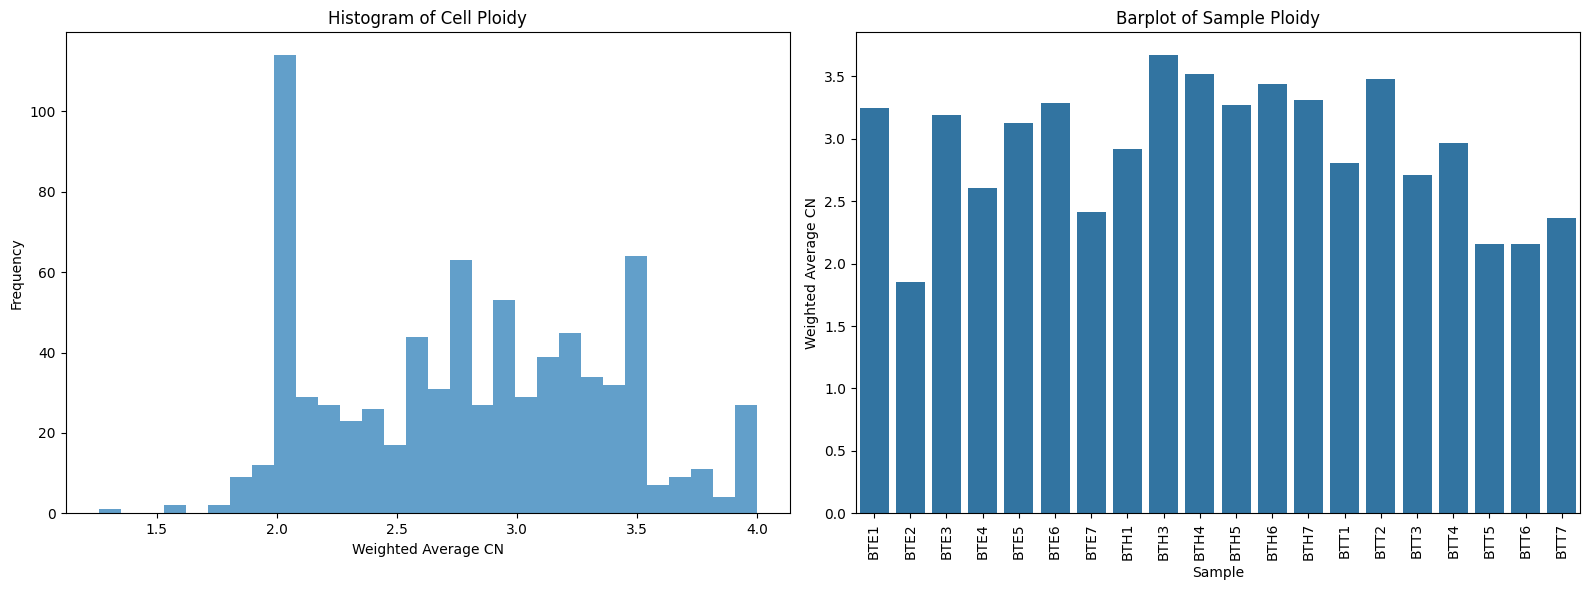

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))

# Plot histogram of cell ploidy
cell_ploidy['weighted_avg_CN'].plot.hist(ax=ax[0], bins=30, alpha=0.7)
ax[0].set_title('Histogram of Cell Ploidy')
ax[0].set_xlabel('Weighted Average CN')
ax[0].set_ylabel('Frequency')

# Plot barplot of sample ploidy
sns.barplot(x='sample', y='weighted_avg_CN', data=sample_ploidy, ax=ax[1])
ax[1].set_title('Barplot of Sample Ploidy')
ax[1].set_xlabel('Sample')
ax[1].set_ylabel('Weighted Average CN')
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

<Figure size 2400x800 with 0 Axes>

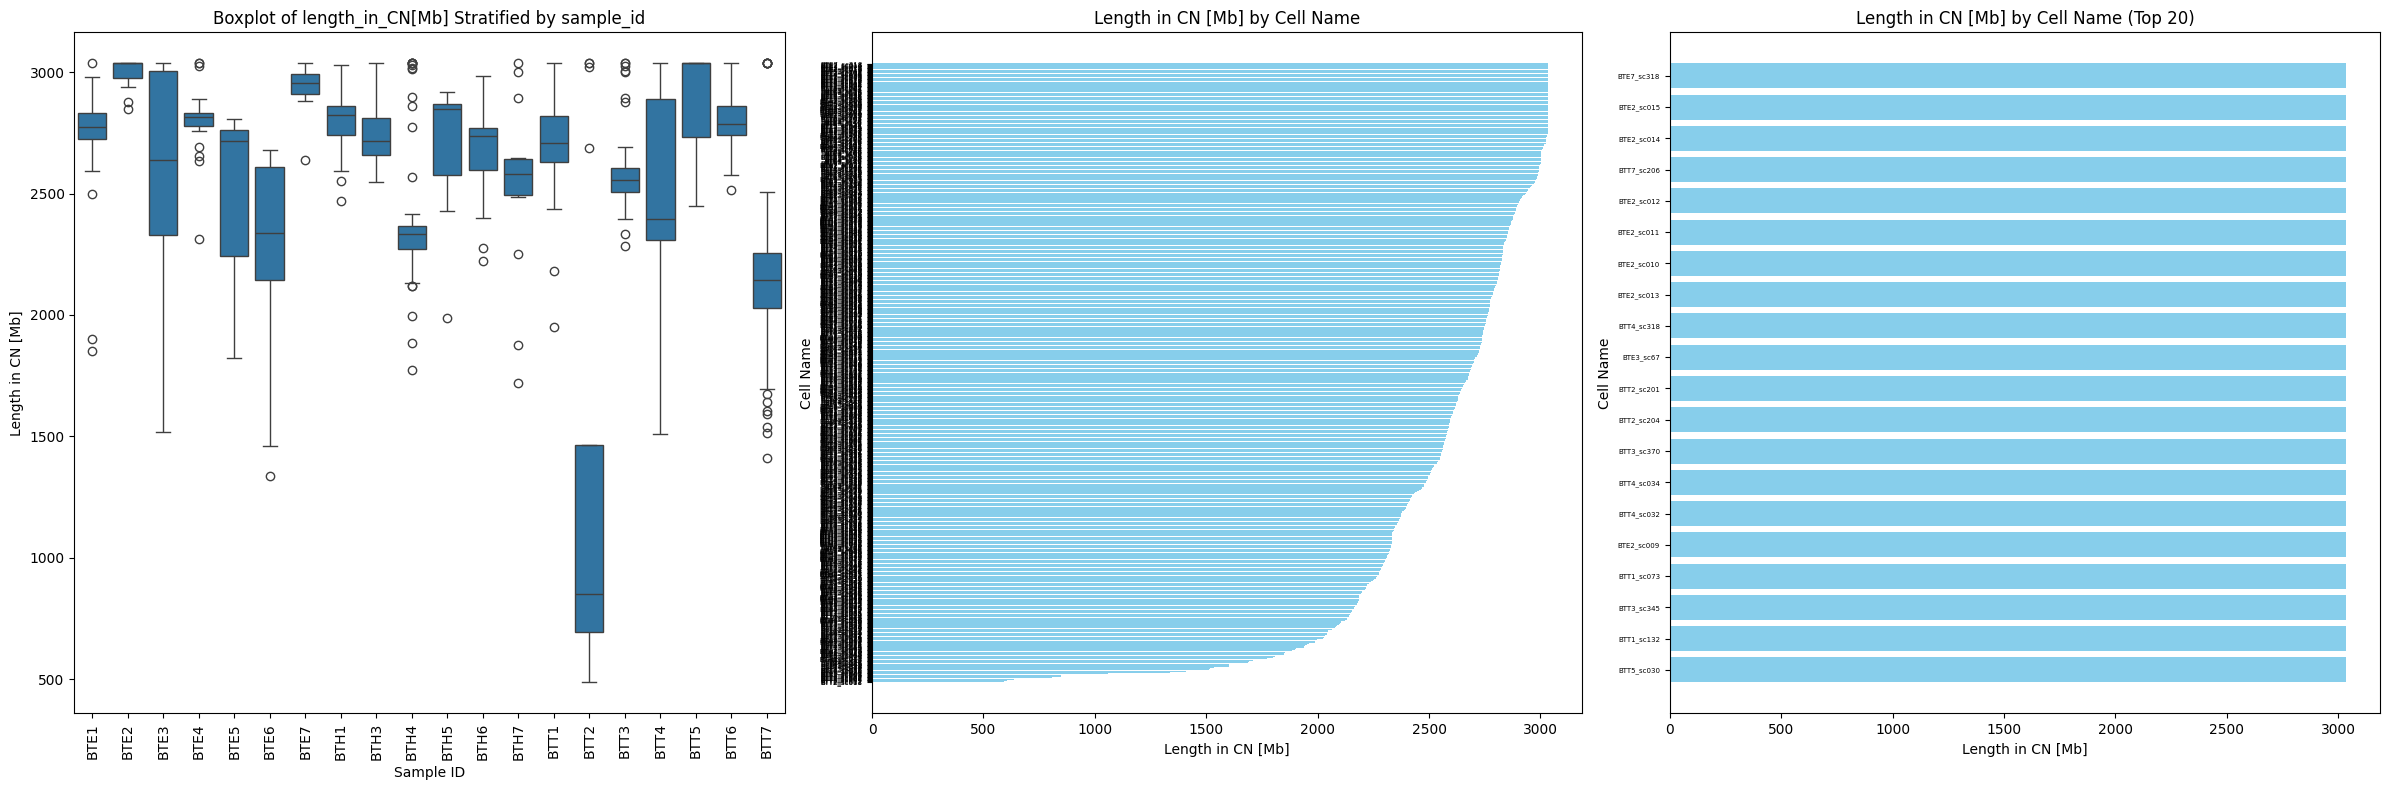

In [27]:
plt.figure(figsize=(24, 8))  # Adjust width for better spacing

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(ncols=3, figsize=(24, 8))

# First plot: Boxplot of length_in_CN[Mb] Stratified by sample_id
sns.boxplot(data=merged_cell_data, x='sample_id', y='length_in_CN[Mb]', ax=axes[0])
axes[0].set_title('Boxplot of length_in_CN[Mb] Stratified by sample_id')
axes[0].set_xlabel('Sample ID')
axes[0].set_ylabel('Length in CN [Mb]')
axes[0].tick_params(axis='x', rotation=90)

# Sort the data by 'length_in_CN[Mb]' in descending order
sorted_data = merged_cell_data.sort_values(by='length_in_CN[Mb]', ascending=False)

# Second plot: Bar plot of length_in_CN[Mb] by Cell Name (all cells)
axes[1].barh(sorted_data['cell_name'], sorted_data['length_in_CN[Mb]'], color='skyblue')
axes[1].set_xlabel('Length in CN [Mb]')
axes[1].set_ylabel('Cell Name')
axes[1].set_title('Length in CN [Mb] by Cell Name')
axes[1].invert_yaxis()  # Invert y-axis to have the highest values at the top
axes[1].tick_params(axis='y', labelsize=5)

# Third plot: Bar plot of length_in_CN[Mb] by Cell Name (top 20 cells)
axes[2].barh(sorted_data['cell_name'].head(20), sorted_data['length_in_CN[Mb]'].head(20), color='skyblue')
axes[2].set_xlabel('Length in CN [Mb]')
axes[2].set_ylabel('Cell Name')
axes[2].set_title('Length in CN [Mb] by Cell Name (Top 20)')
axes[2].invert_yaxis()  # Invert y-axis to have the highest values at the top
axes[2].tick_params(axis='y', labelsize=5)

plt.tight_layout()
plt.show()


In [28]:
all_cells = merged_cell_data['cell_name']
sel_cells = transformed_cancer_cells + normal_curated_cells + remnant_cells

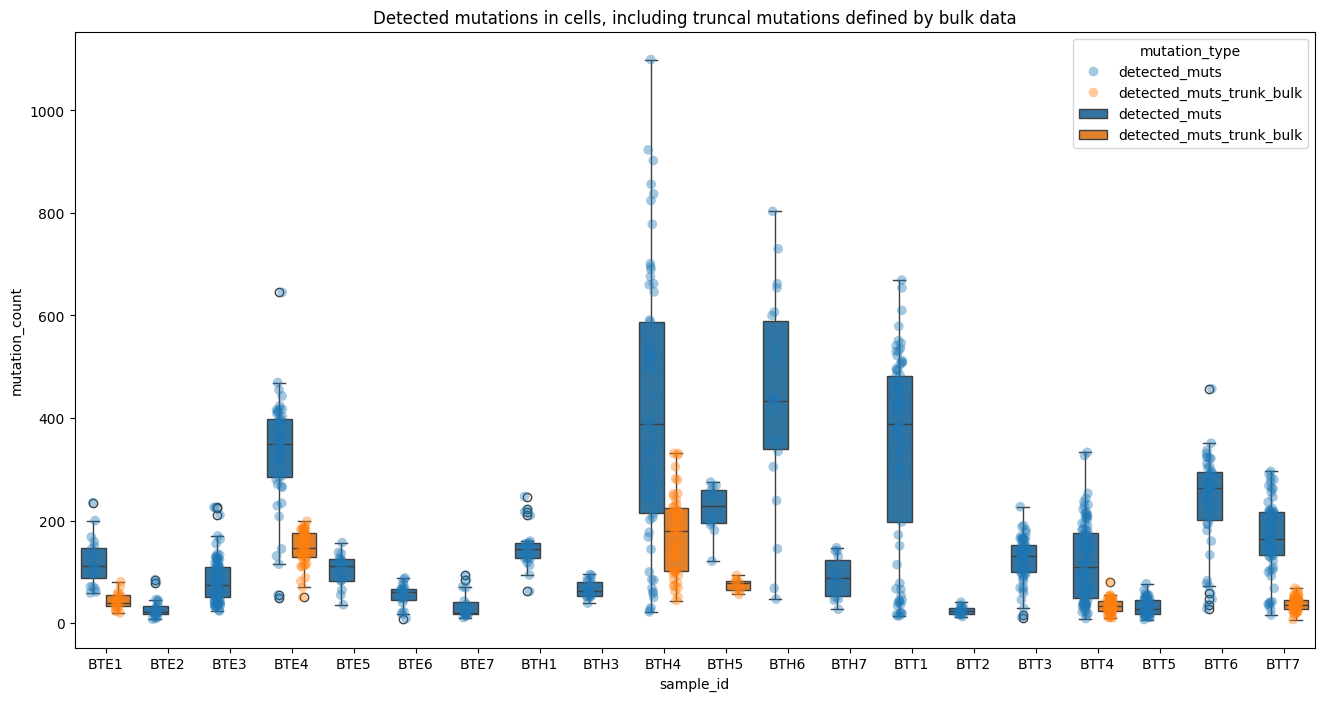

In [29]:
# Plotting
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(16, 8))  # Width x Height in inches

# Melt the dataframe to long format
melted_data = merged_cell_data.melt(id_vars=['sample_id'], value_vars=['detected_muts', 'detected_muts_trunk_bulk'], 
                                    var_name='mutation_type', value_name='mutation_count')

# Create the stripplot
sns.stripplot(
    x='sample_id',
    y='mutation_count',
    hue='mutation_type',
    data=melted_data,
    jitter=True,
    dodge=True,
    alpha=0.4,
    size=7  # Increase the size of the points
)



# Overlay the boxplot with transparency
boxplot = sns.boxplot(
    x='sample_id',
    y='mutation_count',
    hue='mutation_type',
    data=melted_data,
    width=0.8
)

plt.title('Detected mutations in cells, including truncal mutations defined by bulk data')
plt.show()

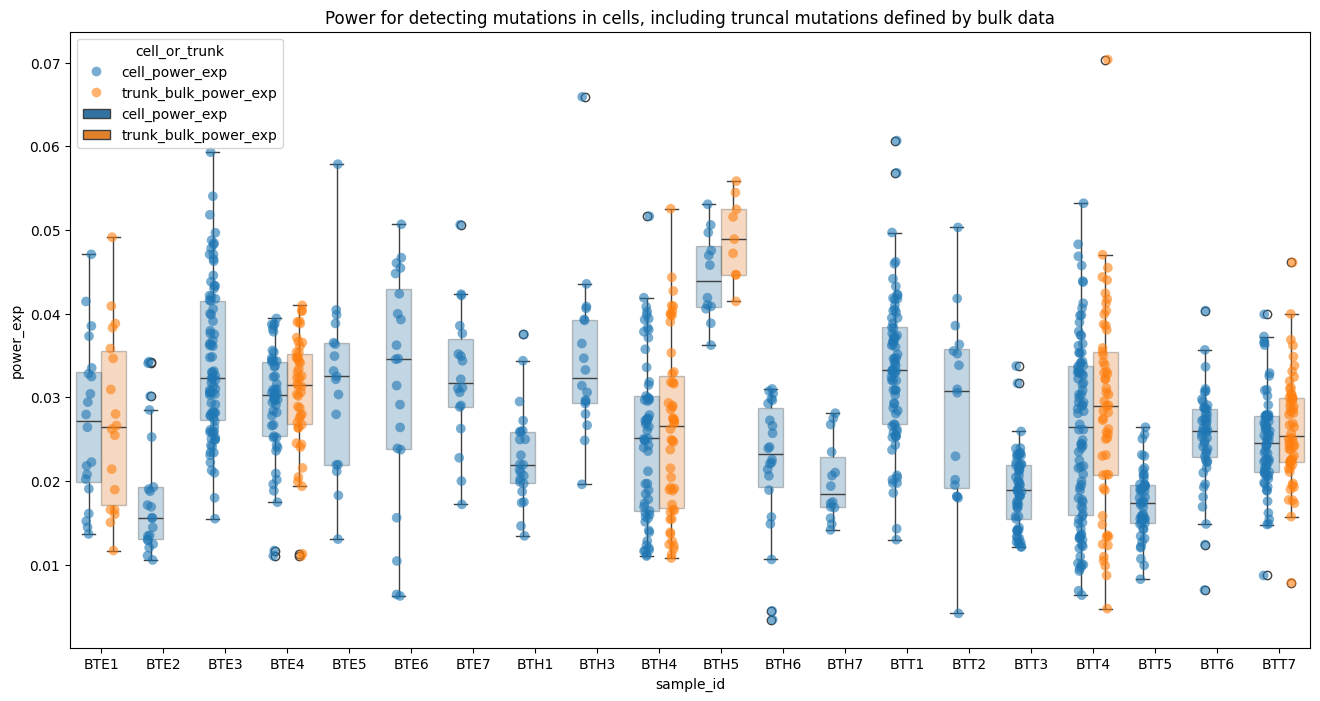

In [30]:
#merged_cell_data[['sample_id', 'power_burden_product_sum', 'total_burden', 'cell_power_exp', 'trunk_bulk_power_exp', 'mult_avg', 'mult_avg_trunk_bulk']]
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(16, 8))  # Width x Height in inches

# Melt the dataframe to long format
melted_data = merged_cell_data.melt(id_vars=['sample_id'], value_vars=['cell_power_exp', 'trunk_bulk_power_exp'], 
                                    var_name='cell_or_trunk', value_name='power_exp')


# Create the stripplot
sns.stripplot(
    x='sample_id',
    y='power_exp',
    hue='cell_or_trunk',
    data=melted_data,
    jitter=True,
    dodge=True,
    alpha=0.6,
    size=7  # Increase the size of the points
)



# Overlay the boxplot with transparency
boxplot = sns.boxplot(
    x='sample_id',
    y='power_exp',
    hue='cell_or_trunk',
    data=melted_data,
    width=0.8
)

# Set transparency (alpha) for the boxes
for patch in boxplot.patches:
    patch.set_alpha(0.3)  # Adjust transparency here

plt.title('Power for detecting mutations in cells, including truncal mutations defined by bulk data')


plt.savefig(
    power_fig_fn,
    format='pdf',
    dpi=300,                # High resolution
    bbox_inches='tight',    # Trim whitespace
    metadata={'Creator': 'Matplotlib'}  # Metadata for Illustrator
)
plt.show()


In [31]:
merged_cell_data['cell_power_exp'].median()

np.float64(0.026296409539355994)

In [32]:
merged_cell_data['cell_power_exp'].quantile(0.25)

np.float64(0.019538843376318876)

In [33]:
merged_cell_data['cell_power_exp'].quantile(0.75)

np.float64(0.033575235028603406)

/tmp/ipykernel_3136766/673818293.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = merged_cell_data2_sigs_sel.groupby(['sample_id_x', 'data_type_x'])[['burden_diploid_corr_SBS1_merged_normal']].median().reset_index()


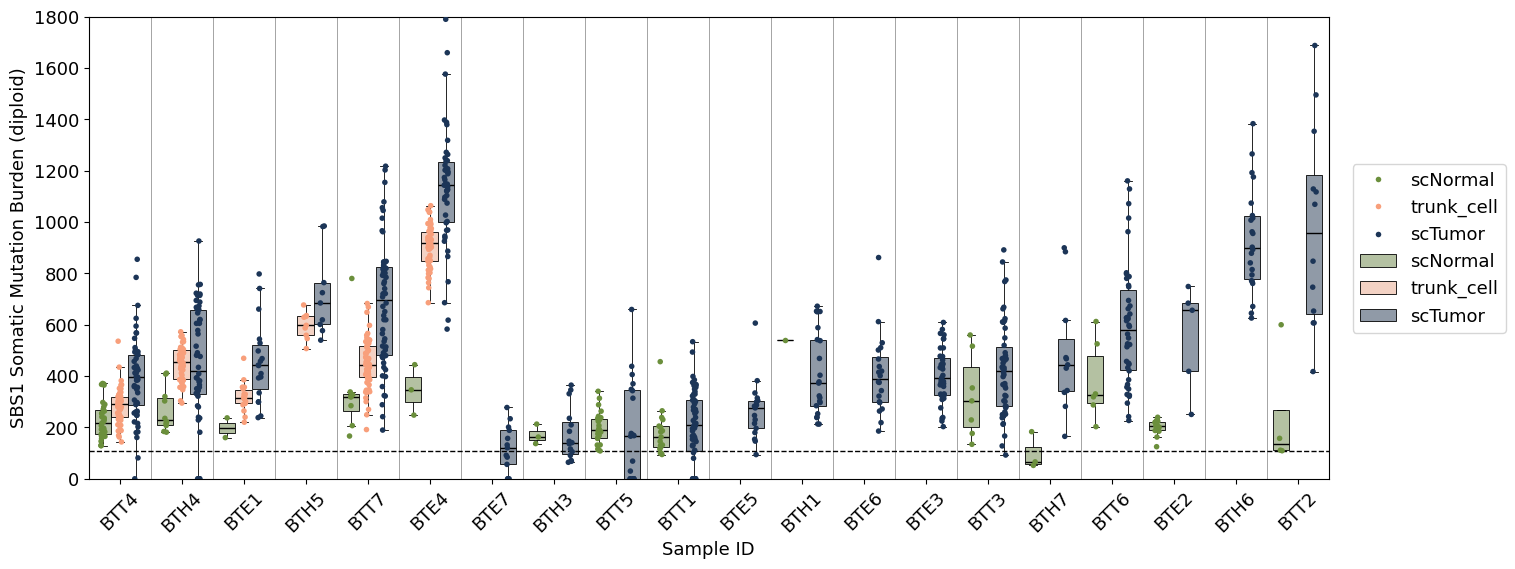

In [34]:
# the approach to signatures in normal cells is different


sel_cells = transformed_cancer_cells + normal_curated_cells
sel_cells2 = sel_cells + [c + '_trunk' for c in sel_cells]
merged_cell_data2_sigs_sel = merged_cell_data2_sigs[merged_cell_data2_sigs['cell_name'].isin(sel_cells2)].copy()
# Remove absent categories in data_type_x column
merged_cell_data2_sigs_sel['data_type_x'] = merged_cell_data2_sigs_sel['data_type_x'].cat.remove_unused_categories()
merged_cell_data2_sigs_sel = merged_cell_data2_sigs_sel[merged_cell_data2_sigs_sel['data_type_x'].isin(['scTumor', 'scNormal', 'trunk_cell'])]



custom_order = ['BTT4', 'BTH4','BTE1', 'BTH5',  'BTT7', 'BTE4'] 


df_grouped = merged_cell_data2_sigs_sel.groupby(['sample_id_x', 'data_type_x'])[['burden_diploid_corr_SBS1_merged_normal']].median().reset_index()

# Pivot the table to wide format
df_wide = df_grouped.pivot(index='sample_id_x', columns='data_type_x', values='burden_diploid_corr_SBS1_merged_normal')

# Reset index to make `sample_id_x` a column again
df_wide.reset_index(inplace=True)

df_wide['tumor_normal_diff'] = df_wide['scTumor'] - df_wide['scNormal']
df_wide['tumor_normal_diff'] = df_wide['tumor_normal_diff'].fillna(0)

# Sort by 'tumor_normal_diff' in ascending order
df_wide = df_wide.sort_values(by='scTumor', ascending=True)

custom_order = custom_order + [c for c in df_wide['sample_id_x'] if c not in custom_order] 

merged_cell_data2_sigs_sel['sample_id_x'] = pd.Categorical(merged_cell_data2_sigs_sel['sample_id_x'], 
                                                           categories=custom_order, ordered=True)


mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 13  

plt.figure(figsize=(16, 6))

# Set font to Arial for Illustrator compatibility
#matplotlib.rcParams['font.family'] = 'Arial'

# Define a color palette for the levels of data_type_x
palette = {
    'scTumor': '#1C3557',
    'scNormal': '#6B8F3C',
    'trunk_tree': 'green',
    'trunk_cell': '#F89F7B',
    'normal_merged': 'orange',
    'other': 'gray'
}

# Create the stripplot
sns.stripplot(
    x='sample_id_x',
    y='burden_diploid_corr_SBS1_merged_normal',
    hue='data_type_x',  # Conditional column
    data=merged_cell_data2_sigs_sel,
    jitter=True,
    dodge=True,  # Set dodge to True for alignment
    alpha=1,
    size=4,  # Increase the size of the points
    palette=palette  # Assign the color palette
)

# Overlay the boxplot with transparency
boxplot = sns.boxplot(
    x='sample_id_x',
    y='burden_diploid_corr_SBS1_merged_normal',
    hue='data_type_x',  # Conditional column
    data=merged_cell_data2_sigs_sel,
    width=0.8,
    palette=palette,  # Assign the color palette
    linewidth=1,  # Make the black lines thicker
    showfliers=False,  # Do not show outliers
    boxprops=dict(edgecolor='black', linewidth=0.6),
    whiskerprops=dict(color='black',  linewidth=0.6),
    capprops=dict(color='black',  linewidth=0.6),
    medianprops=dict(color='black'),
    flierprops=dict(markeredgecolor='black', linewidth=0.5)
)

# Remove the legend for the stripplot to avoid duplication
sns.move_legend(boxplot, "upper right")

for patch in boxplot.patches:
    patch.set_facecolor((patch.get_facecolor()[0],  # Retain original color
                         patch.get_facecolor()[1], 
                         patch.get_facecolor()[2], 
                         0.5))  # Set alpha for transparency

# Add vertical dividers
for i in range(1, 20):
    plt.axvline(x=i - 0.5, color='grey', linewidth=0.5)

# Customize the plot
plt.ylim(0, 1800)
plt.xlabel('Sample ID')
plt.ylabel('SBS1 Somatic Mutation Burden (diploid)')
plt.xticks(rotation=45)

# Remove the legend
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 0.7))
#plt.legend().remove()

plt.axhline(y=109, color='k', linestyle='--', linewidth=1)
# Save as PDF with editable text
plt.savefig(
    figure5a_fn,
    format='pdf',
    dpi=300,                # High resolution
    bbox_inches='tight',    # Trim whitespace
    metadata={'Creator': 'Matplotlib'}  # Metadata for Illustrator
)
plt.show()

merged_cell_data2_sigs_sel.to_csv(per_cell_sigs_exposures_fn)


In [35]:
summary_table = (
    merged_cell_data2_sigs_sel
    .groupby(['sample_id_x', 'data_type_x'])['burden_diploid_corr_SBS1_merged_normal']
    .agg(
        count = 'count',
        mean_value = 'median',
        Q1 = lambda x: x.quantile(0.25),
        Q3 = lambda x: x.quantile(0.75)
    )
    .reset_index()
)

summary_table['IQR'] = summary_table['Q3'] - summary_table['Q1']

# Reorder columns for clarity
summary_table = summary_table[['sample_id_x', 'data_type_x', 'count', 'mean_value', 'Q1', 'Q3', 'IQR']]

print(summary_table)

# Save to CSV
summary_table.to_csv('../../data_scNanoSeq/output/Fig4A_summary_table.csv', index=False)


   sample_id_x data_type_x  count   mean_value          Q1           Q3  \
0         BTT4    scNormal     31   217.098850  174.134873   267.219797   
1         BTT4  trunk_cell     57   290.589354  240.514704   320.420857   
2         BTT4     scTumor     57   395.513597  288.903714   482.618935   
3         BTH4    scNormal     10   228.905281  209.443909   316.248998   
4         BTH4  trunk_cell     50   456.845771  389.257412   500.777955   
5         BTH4     scTumor     50   421.837721  329.281030   655.851895   
6         BTE1    scNormal      2   198.887441  179.661417   218.113464   
7         BTE1  trunk_cell     18   315.599498  293.979306   344.689872   
8         BTE1     scTumor     18   442.067640  349.370556   520.916366   
9         BTH5    scNormal      0          NaN         NaN          NaN   
10        BTH5  trunk_cell      9   597.814988  559.249687   632.814005   
11        BTH5     scTumor      9   684.981878  601.543507   764.300250   
12        BTT7    scNorma

/tmp/ipykernel_3136766/2323156509.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['sample_id_x', 'data_type_x'])['burden_diploid_corr_SBS1_merged_normal']


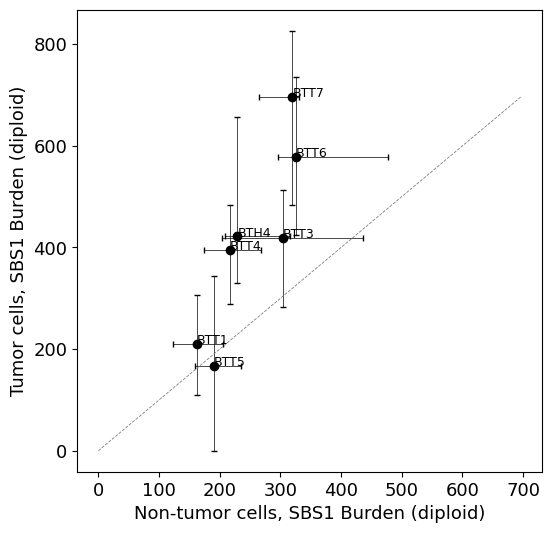

In [36]:
# Assume `summary_table` has been generated as discussed earlier

# Separate normal and tumor rows
normal_df = summary_table[summary_table['data_type_x'] == 'scNormal']
tumor_df = summary_table[summary_table['data_type_x'] == 'scTumor']

# Merge them side-by-side on sample_id_x
plot_df = pd.merge(
    normal_df,
    tumor_df,
    on='sample_id_x',
    suffixes=('_normal', '_tumor')
)

# Keep only rows where both normal and tumor have > 5 data points
plot_df = plot_df[
    (plot_df['count_normal'] > 5) &
    (plot_df['count_tumor'] > 5)
]

# Drop rows where either mean is NaN (in case of missing data)
plot_df = plot_df.dropna(subset=['mean_value_normal', 'mean_value_tumor'])

# Compute asymmetric error bars
xerr = np.array([
    plot_df['mean_value_normal'] - plot_df['Q1_normal'],    # lower error
    plot_df['Q3_normal'] - plot_df['mean_value_normal']     # upper error
])

yerr = np.array([
    plot_df['mean_value_tumor'] - plot_df['Q1_tumor'],      # lower error
    plot_df['Q3_tumor'] - plot_df['mean_value_tumor']       # upper error
])

# Plot
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(6, 6))  # Width x Height in inches

plt.errorbar(
    x=plot_df['mean_value_normal'],
    y=plot_df['mean_value_tumor'],
    xerr=xerr,
    yerr=yerr,
    fmt='o',
    color='k',
    ecolor='k',
    elinewidth=0.5,
    capsize=2
)

# Add sample labels
for _, row in plot_df.iterrows():
    plt.text(
        row['mean_value_normal'],
        row['mean_value_tumor'],
        row['sample_id_x'],
        fontsize=9
    )

# Add diagonal reference line
max_burden = max(plot_df['mean_value_normal'].max(), plot_df['mean_value_tumor'].max())
plt.plot([0, max_burden], [0, max_burden], color='gray', linestyle='--', linewidth=0.6)

# Axis labels
plt.xlabel('Non-tumor cells, SBS1 Burden (diploid)')
plt.ylabel('Tumor cells, SBS1 Burden (diploid)')

# Save figure
plt.savefig(
    figure5b_fn,
    format='pdf',
    dpi=300,
    bbox_inches='tight',
    metadata={'Creator': 'Matplotlib'}
)
plt.show()



In [37]:
plot_df

,sample_id_x,data_type_x_normal,count_normal,mean_value_normal,Q1_normal,Q3_normal,IQR_normal,data_type_x_tumor,count_tumor,mean_value_tumor,Q1_tumor,Q3_tumor,IQR_tumor
0,BTT4,scNormal,31,217.098850,174.134873,267.219797,93.084924,scTumor,57,395.513597,288.903714,482.618935,193.715221
1,BTH4,scNormal,10,228.905281,209.443909,316.248998,106.805089,scTumor,50,421.837721,329.281030,655.851895,326.570865
4,BTT7,scNormal,8,319.575451,265.393288,330.188887,64.795599,scTumor,58,696.773093,482.611605,826.555506,343.943901
8,BTT5,scNormal,25,190.909594,159.712271,234.607730,74.895459,scTumor,20,166.977365,0.000000,344.562363,344.562363
9,BTT1,scNormal,17,162.734452,122.394952,205.338372,82.943420,scTumor,60,209.892319,108.808185,306.774037,197.965852
14,BTT3,scNormal,7,303.577496,203.047680,435.408045,232.360365,scTumor,50,419.244677,282.102163,512.684946,230.582784
16,BTT6,scNormal,6,324.939005,295.612707,476.882484,181.269777,scTumor,42,578.501059,423.742554,734.667296,310.924742


In [38]:
xerr

array([[ 42.96397668,  19.46137226,  54.18216259,  31.19732341,
         40.33949992, 100.52981587,  29.32629849],
       [ 50.12094731,  87.34371698,  10.61343664,  43.6981358 ,
         42.60392056, 131.83054919, 151.94347885]])

In [39]:
tumor_df

,sample_id_x,data_type_x,count,mean_value,Q1,Q3,IQR
2,BTT4,scTumor,57,395.513597,288.903714,482.618935,193.715221
5,BTH4,scTumor,50,421.837721,329.281030,655.851895,326.570865
8,BTE1,scTumor,18,442.067640,349.370556,520.916366,171.545811
11,BTH5,scTumor,9,684.981878,601.543507,764.300250,162.756742
14,BTT7,scTumor,58,696.773093,482.611605,826.555506,343.943901
17,BTE4,scTumor,46,1142.866599,998.791132,1233.144403,234.353271
20,BTE7,scTumor,13,120.700161,56.262227,188.803256,132.541029
23,BTH3,scTumor,15,140.748002,98.232926,222.815508,124.582582
26,BTT5,scTumor,20,166.977365,0.000000,344.562363,344.562363
29,BTT1,scTumor,60,209.892319,108.808185,306.774037,197.965852


In [40]:
merged_cell_data2_sigs_sel['data_type_x'].value_counts()

data_type_x
trunk_cell    585
scTumor       585
scNormal      136
Name: count, dtype: int64

In [41]:
merged_data2_sigs = merged_cell_data2_sigs_sel.copy()

median_normal_burden_per_sample = merged_data2_sigs[merged_data2_sigs['data_type_x'] == 'scNormal'].groupby('sample_id_x',  observed=True)[['burden_diploid_corr_SBS1_merged_normal', 'burden_diploid_corr']].median().reset_index()
# scNormal; burden_diploid_corr_SBS1_merged_normal
filtered_groups_normal = merged_data2_sigs[merged_data2_sigs['data_type_x']=='scNormal'].groupby('sample_id_x',  observed=True).filter(lambda x: len(x) >= 5)
median_normal_burden_per_sample = filtered_groups_normal[filtered_groups_normal['data_type_x']=='scNormal'].groupby('sample_id_x',  observed=True)[['burden_diploid_corr_SBS1_merged_normal', 'burden_diploid_corr']].median().reset_index()
# Filter groups with at least 5 observations

median_normal_burden_per_sample = median_normal_burden_per_sample.rename(
    columns={median_normal_burden_per_sample.columns[1]: 'normal_' + median_normal_burden_per_sample.columns[1],
             median_normal_burden_per_sample.columns[2]: 'normal_' + median_normal_burden_per_sample.columns[2]})

# Calculate the median total_burden_SBS1 per sample_id_x for filtered groups
counts = merged_data2_sigs[merged_data2_sigs['data_type_x'] == 'scTumor'].groupby('sample_id_x',  observed=True).size()
# scTumor: burden_diploid_corr_SBS1_merged_normal
filtered_groups_tumor = merged_data2_sigs[merged_data2_sigs['data_type_x']=='scTumor'].groupby('sample_id_x',  observed=True).filter(lambda x: len(x) >= 5)

# Calculate the median total_burden_SBS1 per sample_id_x for filtered groups
median_tumor_burden_per_sample = filtered_groups_tumor.groupby('sample_id_x',  observed=True)[['burden_diploid_corr_SBS1_merged_normal', 'burden_diploid_corr']].median().reset_index()
median_tumor_burden_per_sample = median_tumor_burden_per_sample.rename(
    columns={median_tumor_burden_per_sample.columns[1]: 'tumor_' + median_tumor_burden_per_sample.columns[1],
             median_tumor_burden_per_sample.columns[2]: 'tumor_' + median_tumor_burden_per_sample.columns[2]}
)

tumor_normal_median_sbs1_burden = pd.merge(median_normal_burden_per_sample, median_tumor_burden_per_sample, on = 'sample_id_x', how='outer')
# trunk_cell: burden_diploid_corr_SBS1_merged_normal
filtered_groups = merged_data2_sigs[merged_data2_sigs['data_type_x']=='trunk_cell']

# Calculate the median total_burden_SBS1 per sample_id_x for filtered groups
trunk_burden_per_sample = filtered_groups.groupby('sample_id_x',  observed=True)[['burden_diploid_corr_SBS1_merged_normal', 'burden_diploid_corr']].median().reset_index()
trunk_burden_per_sample = trunk_burden_per_sample.rename(
    columns={trunk_burden_per_sample.columns[1]: 'trunk_' + trunk_burden_per_sample.columns[1],
             trunk_burden_per_sample.columns[2]: 'trunk_' + trunk_burden_per_sample.columns[2]}
)
# do not use the G correction, since this cannot be applied to trunk
tumor_trunk_median_sbs1_burden = pd.merge(median_tumor_burden_per_sample, trunk_burden_per_sample, on='sample_id_x')
normal_trunk_median_sbs1_burden = pd.merge(median_normal_burden_per_sample, trunk_burden_per_sample, on='sample_id_x')
normal_trunk_median_sbs1_burden_sel = normal_trunk_median_sbs1_burden.dropna(subset=['trunk_burden_diploid_corr_SBS1_merged_normal', 
                                                                                 'normal_burden_diploid_corr_SBS1_merged_normal'])

In [42]:
normal_trunk_median_sbs1_burden_sel

,sample_id_x,normal_burden_diploid_corr_SBS1_merged_normal,normal_burden_diploid_corr,trunk_burden_diploid_corr_SBS1_merged_normal,trunk_burden_diploid_corr
0,BTT4,217.098850,1854.534220,290.589354,5725.772851
1,BTH4,228.905281,2202.660794,456.845771,12812.189219
2,BTT7,319.575451,2476.056143,444.878590,9536.141022


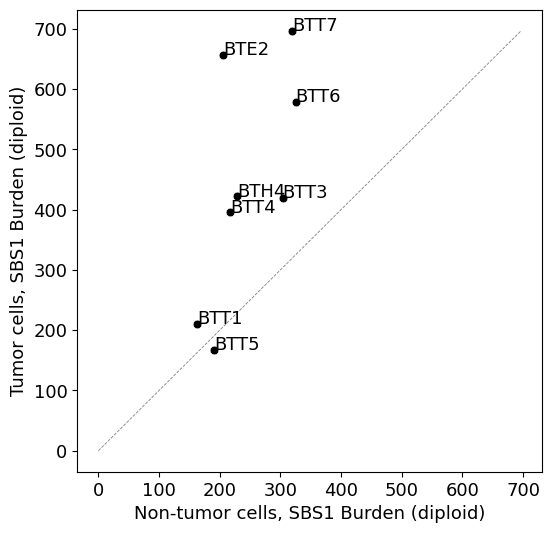

In [43]:
# Filter out rows with NaN values in the columns 'total_burden_SBS1_normal' and 'total_burden_SBS1_tumor'
tumor_normal_median_sbs1_burden_sel = tumor_normal_median_sbs1_burden.dropna(subset=['normal_burden_diploid_corr_SBS1_merged_normal', 
                                                                                 'tumor_burden_diploid_corr_SBS1_merged_normal'])

mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(6, 6))  # Width x Height in inches

sns.scatterplot(
    x='normal_burden_diploid_corr_SBS1_merged_normal',
    y='tumor_burden_diploid_corr_SBS1_merged_normal',
    data=tumor_normal_median_sbs1_burden_sel,
    s=40,
    color='k'  # double the default size
)

# Label data points
for i in range(tumor_normal_median_sbs1_burden_sel.shape[0]):
    plt.text(
        tumor_normal_median_sbs1_burden_sel['normal_burden_diploid_corr_SBS1_merged_normal'].iloc[i],
        tumor_normal_median_sbs1_burden_sel['tumor_burden_diploid_corr_SBS1_merged_normal'].iloc[i],
        tumor_normal_median_sbs1_burden_sel['sample_id_x'].iloc[i]
    )

# Add a diagonal line for reference
max_burden = max(tumor_normal_median_sbs1_burden_sel['normal_burden_diploid_corr_SBS1_merged_normal'].max(), \
                 tumor_normal_median_sbs1_burden_sel['tumor_burden_diploid_corr_SBS1_merged_normal'].max())
plt.plot([0, max_burden], [0, max_burden], color='gray', linestyle='--', linewidth=0.6)
plt.xlabel('Non-tumor cells, SBS1 Burden (diploid)')
plt.ylabel('Tumor cells, SBS1 Burden (diploid)')
#plt.title('SBS1 Burden between Normal and Tumor Samples, diploid')
plt.savefig(
    figure5b_fn,
    format='pdf',
    dpi=300,                # High resolution
    bbox_inches='tight',    # Trim whitespace
    metadata={'Creator': 'Matplotlib'}  # Metadata
)
plt.show()

In [44]:
(tumor_normal_median_sbs1_burden_sel['tumor_burden_diploid_corr_SBS1_merged_normal']/tumor_normal_median_sbs1_burden_sel['normal_burden_diploid_corr_SBS1_merged_normal']).median()


np.float64(1.8010753996459803)

In [45]:
(tumor_normal_median_sbs1_burden_sel['tumor_burden_diploid_corr_SBS1_merged_normal']/tumor_normal_median_sbs1_burden_sel['normal_burden_diploid_corr_SBS1_merged_normal'])

0     1.821813
1     1.842848
4     2.180309
8     0.874641
9     1.289784
14    1.381014
16    1.780337
17    3.200013
dtype: float64

/tmp/ipykernel_3136766/2392027128.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['sample_id_x', 'data_type_x'])['burden_diploid_corr_SBS1_merged_normal']


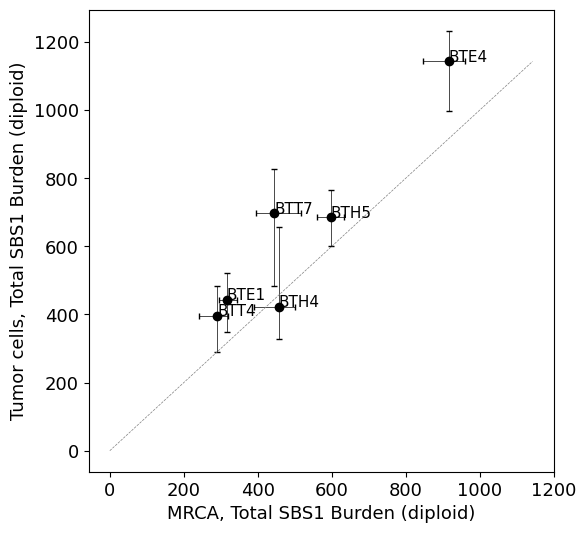

In [46]:
# Compute summary table for tumor and trunk
summary_table_tt = (
    merged_cell_data2_sigs_sel
    .groupby(['sample_id_x', 'data_type_x'])['burden_diploid_corr_SBS1_merged_normal']
    .agg(
        count = 'count',
        mean_value = 'median',
        Q1 = lambda x: x.quantile(0.25),
        Q3 = lambda x: x.quantile(0.75)
    )
    .reset_index()
)

summary_table_tt['IQR'] = summary_table_tt['Q3'] - summary_table_tt['Q1']


# Separate trunk and tumor
trunk_df = summary_table_tt[summary_table_tt['data_type_x'] == 'trunk_cell']
tumor_df = summary_table_tt[summary_table_tt['data_type_x'] == 'scTumor']

# Merge side-by-side
plot_df_tt = pd.merge(
    trunk_df,
    tumor_df,
    on='sample_id_x',
    suffixes=('_trunk', '_tumor')
)

# Filter to only include rows where both have count > 5
plot_df_tt = plot_df_tt[
    (plot_df_tt['count_trunk'] > 5) &
    (plot_df_tt['count_tumor'] > 5)
]

# Drop rows with missing mean values
plot_df_tt = plot_df_tt.dropna(subset=['mean_value_trunk', 'mean_value_tumor'])

# Compute asymmetric error bars
xerr_tt = np.array([
    plot_df_tt['mean_value_trunk'] - plot_df_tt['Q1_trunk'],   # lower
    plot_df_tt['Q3_trunk'] - plot_df_tt['mean_value_trunk']    # upper
])

yerr_tt = np.array([
    plot_df_tt['mean_value_tumor'] - plot_df_tt['Q1_tumor'],   # lower
    plot_df_tt['Q3_tumor'] - plot_df_tt['mean_value_tumor']    # upper
])

# Plot
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(6, 6))

plt.errorbar(
    x=plot_df_tt['mean_value_trunk'],
    y=plot_df_tt['mean_value_tumor'],
    xerr=xerr_tt,
    yerr=yerr_tt,
    fmt='o',
    color='k',
    ecolor='k',
    elinewidth=0.5,
    capsize=2
)

# Add sample labels
for _, row in plot_df_tt.iterrows():
    plt.text(
        row['mean_value_trunk'],
        row['mean_value_tumor'],
        row['sample_id_x'],
        fontsize=11
    )

# Diagonal reference line
max_burden = max(plot_df_tt['mean_value_trunk'].max(), plot_df_tt['mean_value_tumor'].max())
plt.plot([0, max_burden], [0, max_burden], color='gray', linestyle='--', linewidth=0.5)

plt.xlabel('MRCA, Total SBS1 Burden (diploid)')
plt.ylabel('Tumor cells, Total SBS1 Burden (diploid)')

plt.savefig(
    figure5c,
    format='pdf',
    dpi=300,
    bbox_inches='tight',
    metadata={'Creator': 'Matplotlib'}
)
plt.show()



In [47]:
plot_df_tt['excess_burden'] = plot_df_tt['mean_value_tumor'] - plot_df_tt['mean_value_trunk']
plot_df_tt['excess_error'] = np.sqrt(
    (plot_df_tt['IQR_tumor'] / 2) ** 2 +
    (plot_df_tt['IQR_trunk'] / 2) ** 2
)

# Median excess
median_excess = plot_df_tt['excess_burden'].median()

# Use median of individual excess errors as typical uncertainty per sample
typical_error = plot_df_tt['excess_error'].median()

# Estimate error on median by dividing typical individual error by sqrt(n)
n = len(plot_df_tt)
median_error = typical_error / np.sqrt(n)

print(f"Median excess burden (tumor - MRCA): {median_excess:.2f} ± {median_error:.2f}")

conversion_factor = 46.2

median_excess_years = median_excess / conversion_factor
median_error_years = median_error / conversion_factor

print(f"Median late period duration (diagnosis - MRCA): {median_excess_years:.2f} ± {median_error_years:.2f} years")


Median excess burden (tumor - MRCA): 115.70 ± 47.98
Median late period duration (diagnosis - MRCA): 2.50 ± 1.04 years


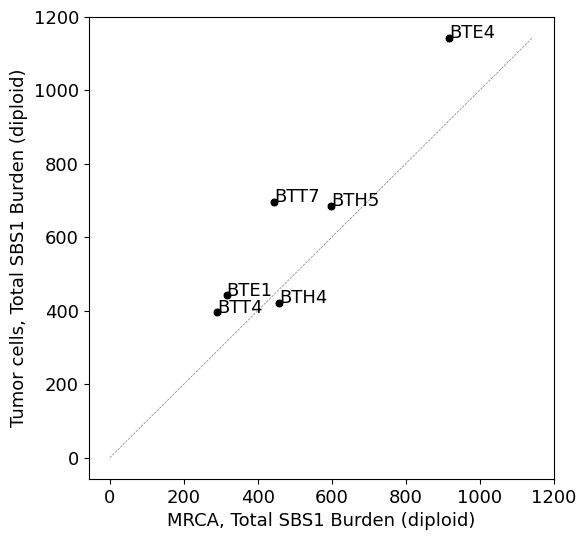

In [48]:
tumor_trunk_median_sbs1_burden=tumor_trunk_median_sbs1_burden[tumor_trunk_median_sbs1_burden['trunk_burden_diploid_corr_SBS1_merged_normal'].notna()]
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(6, 6))  # Width x Height in inches

sns.scatterplot(
    y='tumor_burden_diploid_corr_SBS1_merged_normal',
    x='trunk_burden_diploid_corr_SBS1_merged_normal',
    data=tumor_trunk_median_sbs1_burden,
    s=40,
    color='k'  # double the default size
)

# Label data points
for i in range(tumor_trunk_median_sbs1_burden.shape[0]):
    plt.text(
         tumor_trunk_median_sbs1_burden['trunk_burden_diploid_corr_SBS1_merged_normal'].iloc[i],
        tumor_trunk_median_sbs1_burden['tumor_burden_diploid_corr_SBS1_merged_normal'].iloc[i],
        tumor_trunk_median_sbs1_burden['sample_id_x'].iloc[i]
    )

# Add a diagonal line for reference
max_burden = max(tumor_trunk_median_sbs1_burden['tumor_burden_diploid_corr_SBS1_merged_normal'].max(), tumor_trunk_median_sbs1_burden['trunk_burden_diploid_corr_SBS1_merged_normal'].max())
plt.plot([0, max_burden], [0, max_burden], color='gray', linestyle='--', linewidth=0.5)
plt.ylabel('Tumor cells, Total SBS1 Burden (diploid)')
plt.xlabel('MRCA, Total SBS1 Burden (diploid)')
plt.savefig(
    figure5c,
    format='pdf',
    dpi=300,                # High resolution
    bbox_inches='tight',    # Trim whitespace
    metadata={'Creator': 'Matplotlib'}  # Metadata
)
plt.show()

In [49]:
(tumor_trunk_median_sbs1_burden['tumor_burden_diploid_corr_SBS1_merged_normal'] - tumor_trunk_median_sbs1_burden['trunk_burden_diploid_corr_SBS1_merged_normal'])

0    104.924244
1    -35.008050
2    126.468142
3     87.166890
4    251.894503
5    226.021074
dtype: float64

In [50]:
(tumor_trunk_median_sbs1_burden['tumor_burden_diploid_corr_SBS1_merged_normal'] - tumor_trunk_median_sbs1_burden['trunk_burden_diploid_corr_SBS1_merged_normal']).median()

np.float64(115.69619283840339)

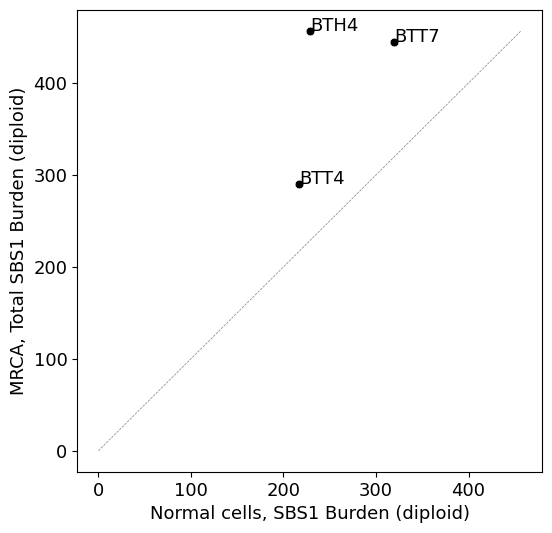

In [51]:
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(6, 6))  # Width x Height in inches

sns.scatterplot(
    x='normal_burden_diploid_corr_SBS1_merged_normal',
    y='trunk_burden_diploid_corr_SBS1_merged_normal',
    data=normal_trunk_median_sbs1_burden_sel,
    s=40,
    color='k' # double the default size
)

for i in range(normal_trunk_median_sbs1_burden_sel.shape[0]):
    plt.text(
         normal_trunk_median_sbs1_burden_sel['normal_burden_diploid_corr_SBS1_merged_normal'].iloc[i],
        normal_trunk_median_sbs1_burden_sel['trunk_burden_diploid_corr_SBS1_merged_normal'].iloc[i],
        normal_trunk_median_sbs1_burden_sel['sample_id_x'].iloc[i]
    )

max_burden = max(normal_trunk_median_sbs1_burden_sel['normal_burden_diploid_corr_SBS1_merged_normal'].max(), 
                 normal_trunk_median_sbs1_burden_sel['trunk_burden_diploid_corr_SBS1_merged_normal'].max())
plt.plot([0, max_burden], [0, max_burden], color='gray', linestyle='--', linewidth=0.5)

plt.xlabel('Normal cells, SBS1 Burden (diploid)')
plt.ylabel('MRCA, Total SBS1 Burden (diploid)')
plt.savefig(
    figure5d,
    format='pdf',
    dpi=300,                # High resolution
    bbox_inches='tight',    # Trim whitespace
    metadata={'Creator': 'Matplotlib'}  # Metadata
)
plt.show()

/tmp/ipykernel_3136766/827754127.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['sample_id_x', 'data_type_x'])['burden_diploid_corr_SBS1_merged_normal']


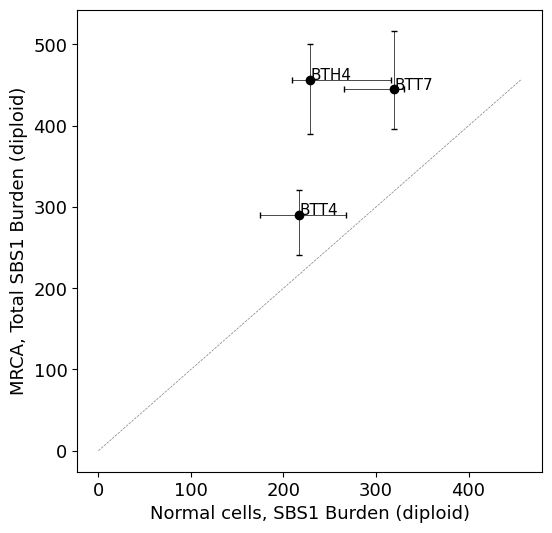

In [52]:

# Compute summary table for normal + trunk
summary_table_nt = (
    merged_cell_data2_sigs_sel
    .groupby(['sample_id_x', 'data_type_x'])['burden_diploid_corr_SBS1_merged_normal']
    .agg(
        count = 'count',
        median_value = 'median',
        Q1 = lambda x: x.quantile(0.25),
        Q3 = lambda x: x.quantile(0.75)
    )
    .reset_index()
)

# Separate normal and trunk
normal_df = summary_table_nt[summary_table_nt['data_type_x'] == 'scNormal']
trunk_df = summary_table_nt[summary_table_nt['data_type_x'] == 'trunk_cell']

# Merge side-by-side
plot_df_nt = pd.merge(
    normal_df,
    trunk_df,
    on='sample_id_x',
    suffixes=('_normal', '_trunk')
)

# Filter for sufficient data points
plot_df_nt = plot_df_nt[
    (plot_df_nt['count_normal'] > 5) &
    (plot_df_nt['count_trunk'] > 5)
].dropna(subset=['median_value_normal', 'median_value_trunk'])

# Compute asymmetric error bars
xerr = np.array([
    plot_df_nt['median_value_normal'] - plot_df_nt['Q1_normal'],  # lower
    plot_df_nt['Q3_normal'] - plot_df_nt['median_value_normal']   # upper
])

yerr = np.array([
    plot_df_nt['median_value_trunk'] - plot_df_nt['Q1_trunk'],    # lower
    plot_df_nt['Q3_trunk'] - plot_df_nt['median_value_trunk']     # upper
])

# Plot
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(6, 6))

plt.errorbar(
    x=plot_df_nt['median_value_normal'],
    y=plot_df_nt['median_value_trunk'],
    xerr=xerr,
    yerr=yerr,
    fmt='o',
    color='k',
    ecolor='k',
    elinewidth=0.5,
    capsize=2
)

# Add sample labels
for _, row in plot_df_nt.iterrows():
    plt.text(
        row['median_value_normal'],
        row['median_value_trunk'],
        row['sample_id_x'],
        fontsize=11
    )

# Diagonal reference line
max_burden = max(plot_df_nt['median_value_normal'].max(), plot_df_nt['median_value_trunk'].max())
plt.plot([0, max_burden], [0, max_burden], color='gray', linestyle='--', linewidth=0.5)

plt.xlabel('Normal cells, SBS1 Burden (diploid)')
plt.ylabel('MRCA, Total SBS1 Burden (diploid)')

plt.savefig(
    figure5d,
    format='pdf',
    dpi=300,
    bbox_inches='tight',
    metadata={'Creator': 'Matplotlib'}
)
plt.show()


In [53]:
normal_trunk_median_sbs1_burden_sel['trunk_burden_diploid_corr_SBS1_merged_normal']/normal_trunk_median_sbs1_burden_sel['normal_burden_diploid_corr_SBS1_merged_normal']

0    1.338512
1    1.995785
2    1.392093
dtype: float64

In [54]:
normal_trunk_median_sbs1_burden_sel

,sample_id_x,normal_burden_diploid_corr_SBS1_merged_normal,normal_burden_diploid_corr,trunk_burden_diploid_corr_SBS1_merged_normal,trunk_burden_diploid_corr
0,BTT4,217.098850,1854.534220,290.589354,5725.772851
1,BTH4,228.905281,2202.660794,456.845771,12812.189219
2,BTT7,319.575451,2476.056143,444.878590,9536.141022
